#### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import glob #
import os 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# local imports
from src.controller import *

2022-09-06 18:43:17.619434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 18:43:17.619458: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### 2. Data processing

In [2]:
'''
    Read text files and store the data in dataframes
    :note: datafiles ending with '_F1.txt' are ignored. Check the difference btw two data files!
'''
col_names=["name","date","time","low","high","open","close","volume","volume2"]
filenames = [filename for filename in glob.glob("data/nifty50/05SEP/*.txt")
            if os.path.isfile(filename) and filename[-7]!='_']

main_df = DataHandler.read_csv(col_names, filenames)

#### 3. Prediction Model

In [3]:
SEQ_LEN = 60 #considering last 60 minutes of data
FUTURE_PERIOD_PREDICT = 3 #predicting for next 3 minutes
'''
    :Strategy: consider the most stable stock in N50 and compare the behaviour of 
               other stocks w.r.t to it.
    :Assumption: HDFC is the most stable stock in N50
    :TODO: Improvise the strategy to include precise reference for the predictions. One can take running average of
           the top 10 companies and make it the reference for comparison.
'''
RATIO_TO_PREDICT = "HDFC"

main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT) #adding future column which is a copy of close column just shifted in time by "FUTURE_PERIOD_PREDICT" timesteps
print(main_df[[f"{RATIO_TO_PREDICT}_close",'future']][:10]) #check the shift of rows in future column by "FUTURE_PERIOD_PREDICT" units  

       HDFC_close   future
time                      
09:08     2454.90  2458.45
09:16     2456.65  2459.00
09:17     2456.30  2460.40
09:18     2458.45  2454.90
09:19     2459.00  2451.20
09:20     2460.40  2456.65
09:21     2454.90  2455.05
09:22     2451.20  2451.60
09:23     2456.65  2449.05
09:24     2455.05  2444.35


/home/akshay/miniconda3/envs/fleetsim/lib/python3.7/site-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == "":


In [4]:
'''
    Add target columns which stores the calls for buying or selling of stocks
'''
main_df['target'] = list(map(Model.classify, main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"]))

print(main_df[[f"{RATIO_TO_PREDICT}_close","future","target"]][:10])

       HDFC_close   future  target
time                              
09:08     2454.90  2458.45       1
09:16     2456.65  2459.00       1
09:17     2456.30  2460.40       1
09:18     2458.45  2454.90       0
09:19     2459.00  2451.20       0
09:20     2460.40  2456.65       0
09:21     2454.90  2455.05       1
09:22     2451.20  2451.60       1
09:23     2456.65  2449.05       0
09:24     2455.05  2444.35       0


In [14]:
print(main_df["target"])

time
09:08    1
09:16    1
09:17    1
09:18    0
09:19    0
        ..
15:30    0
15:31    0
15:33    0
15:42    0
16:56    0
Name: target, Length: 380, dtype: int64


In [4]:
# data preprocessing -> 'close' cloumn already in float datatype.
# taking 'close' column values to predict the trend of nifty index

train_data = data.iloc[:, 4:5].values  

In [5]:
# reslacing the values
# comment: zero mean and unit variance scaling can also be used.
sc = MinMaxScaler(feature_range=(0,1))
train_data = sc.fit_transform(train_data)
train_data.shape

(248, 1)

In [6]:
X_train = []
y_train = []

dataset_size = train_data.shape[0]
cross_val_size = 10

for i in range(cross_val_size, dataset_size): #similar to cross validation technique
    X_train.append(train_data[i-cross_val_size : i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)


In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #adding the batch_size axis
X_train.shape

(238, 10, 1)

### Model building

In [26]:
# TODO: analyse the model on paper first!
model = Sequential()

model.add(LSTM(units=100, return_sequences= True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences= False))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation = 'tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
X_train.shape

(238, 10, 1)

In [27]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=2)

Epoch 1/20
24/24 - 4s - loss: 0.0669 - 4s/epoch - 151ms/step
Epoch 2/20
24/24 - 0s - loss: 0.0192 - 281ms/epoch - 12ms/step
Epoch 3/20
24/24 - 0s - loss: 0.0157 - 271ms/epoch - 11ms/step
Epoch 4/20
24/24 - 0s - loss: 0.0109 - 259ms/epoch - 11ms/step
Epoch 5/20
24/24 - 0s - loss: 0.0104 - 304ms/epoch - 13ms/step
Epoch 6/20
24/24 - 0s - loss: 0.0102 - 274ms/epoch - 11ms/step
Epoch 7/20
24/24 - 0s - loss: 0.0115 - 272ms/epoch - 11ms/step
Epoch 8/20
24/24 - 0s - loss: 0.0101 - 286ms/epoch - 12ms/step
Epoch 9/20
24/24 - 0s - loss: 0.0092 - 270ms/epoch - 11ms/step
Epoch 10/20
24/24 - 0s - loss: 0.0120 - 274ms/epoch - 11ms/step
Epoch 11/20
24/24 - 0s - loss: 0.0084 - 270ms/epoch - 11ms/step
Epoch 12/20
24/24 - 0s - loss: 0.0105 - 262ms/epoch - 11ms/step
Epoch 13/20
24/24 - 0s - loss: 0.0073 - 273ms/epoch - 11ms/step
Epoch 14/20
24/24 - 0s - loss: 0.0084 - 261ms/epoch - 11ms/step
Epoch 15/20
24/24 - 0s - loss: 0.0075 - 271ms/epoch - 11ms/step
Epoch 16/20
24/24 - 0s - loss: 0.0087 - 272ms/epoch

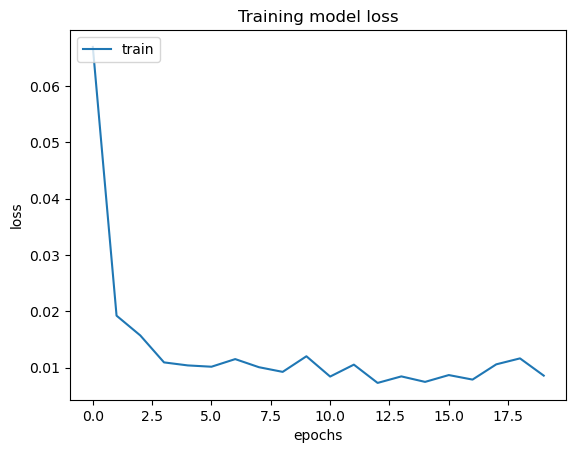

In [28]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper left')
plt.show()

### Model Testing

In [29]:
test_data = pd.read_csv('data/nifty50/data_2018_first_three_months.csv') #import data
test_data = test_data.iloc[:,4:5]

y_test = test_data.iloc[2:, 0:].values

#input arracy for the model

inputClosing = test_data.iloc[:, 0:].values
inputClosing_scaled = sc.transform(inputClosing)

X_test = []

length = len(test_data)
timestep = cross_val_size

for i in range(timestep, length):
    X_test.append(inputClosing_scaled[i - timestep:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [30]:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 7ms/step


In [31]:
predicted_index = sc.inverse_transform(y_pred) # undoing the scaling done on X_train, X_test

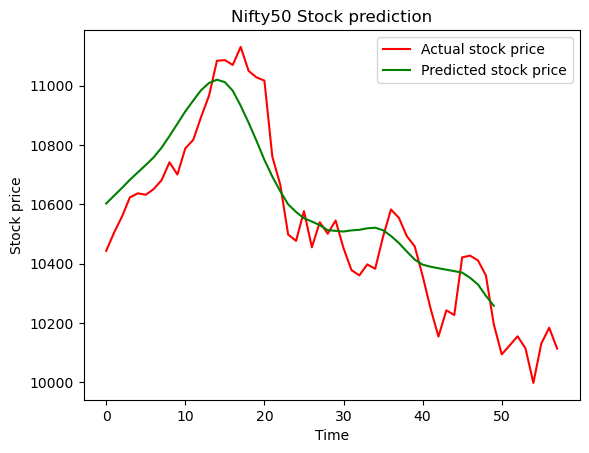

In [32]:
plt.plot(y_test, color = 'red', label='Actual stock price')
plt.plot(predicted_index, color='green', label='Predicted stock price')
plt.title('Nifty50 Stock prediction')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()